<a href="https://colab.research.google.com/github/nanopiero/PREAC/blob/main/notebooks/4_Multimodal_Transformer_test_positional_head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 4 : Régression multimodale avec un Visual Transformer


In [119]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

In [120]:
! git clone https://github.com/nanopiero/PREAC.git

fatal: destination path 'PREAC' already exists and is not an empty directory.


## A. Découverte du problème

In [121]:
pip install einops

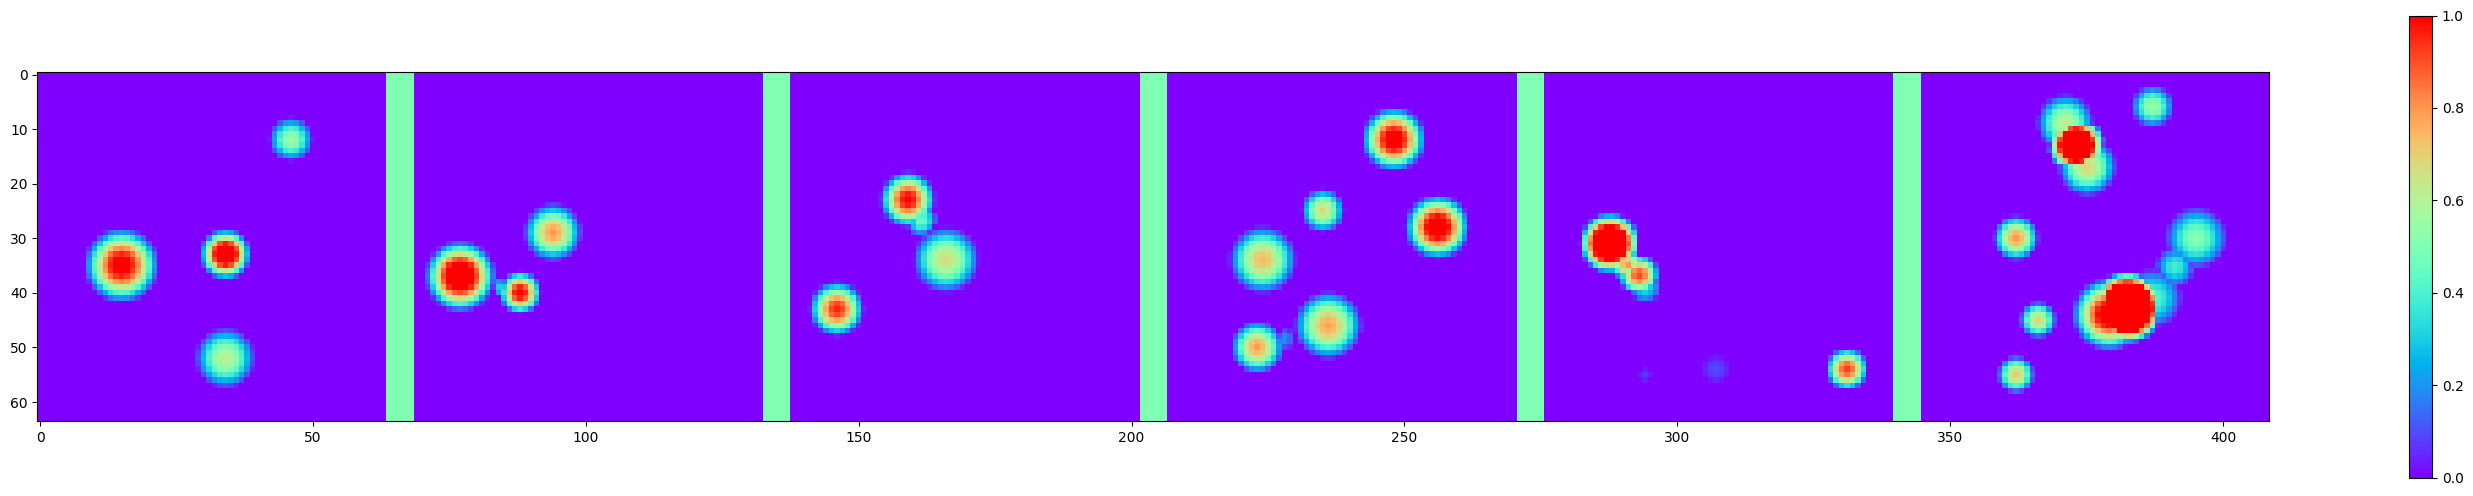

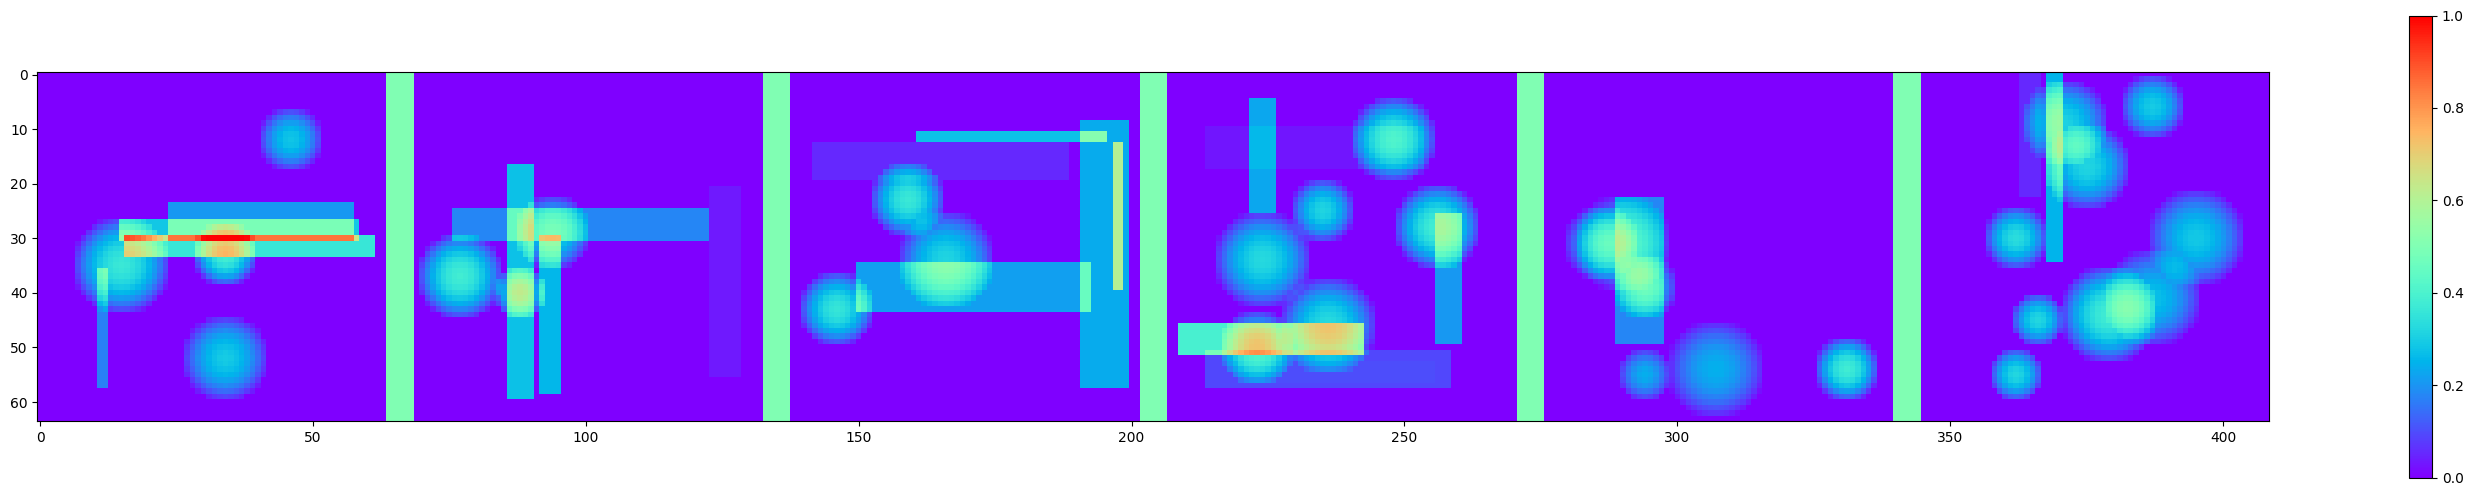

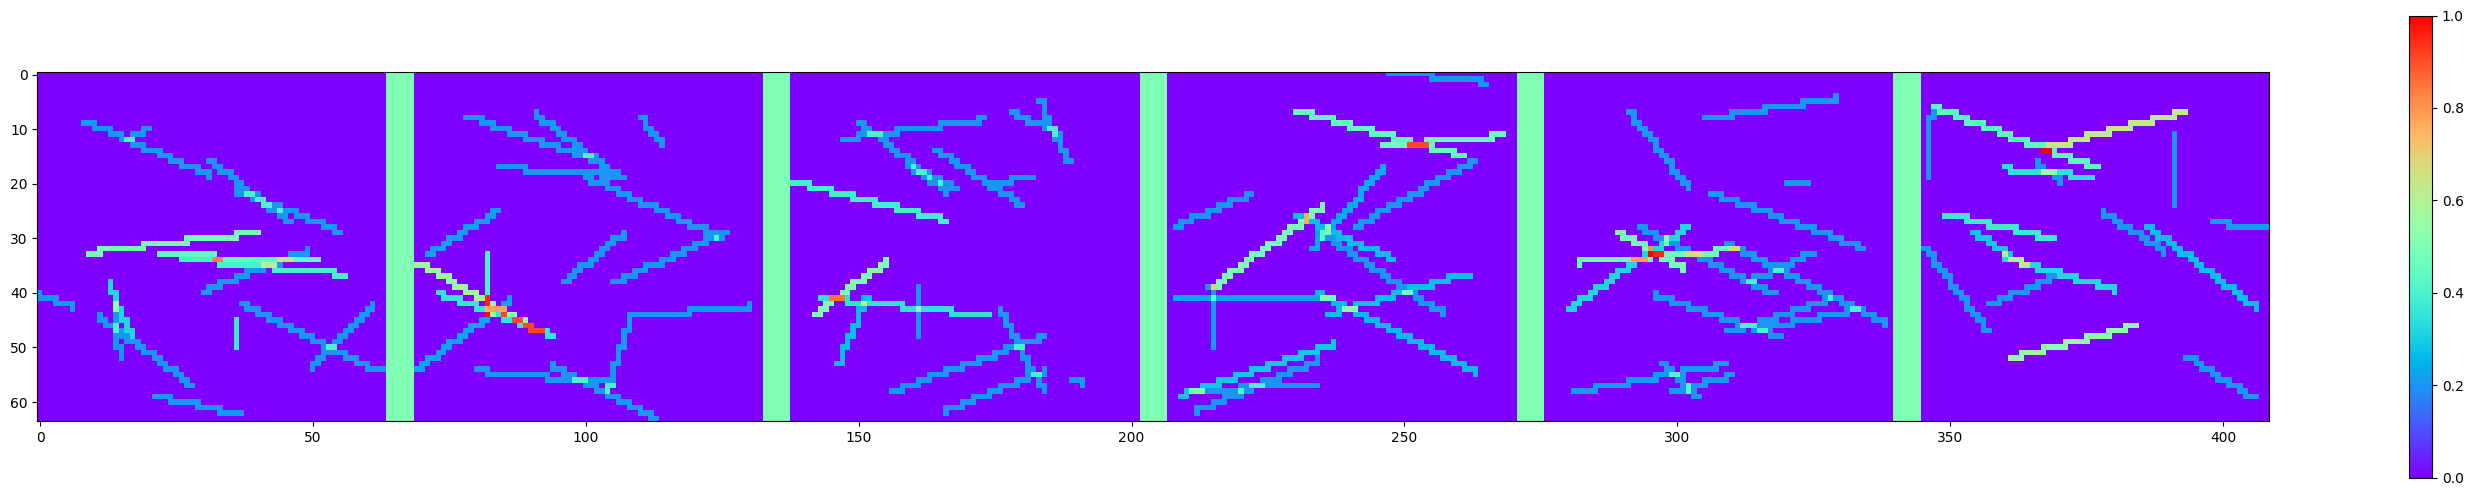

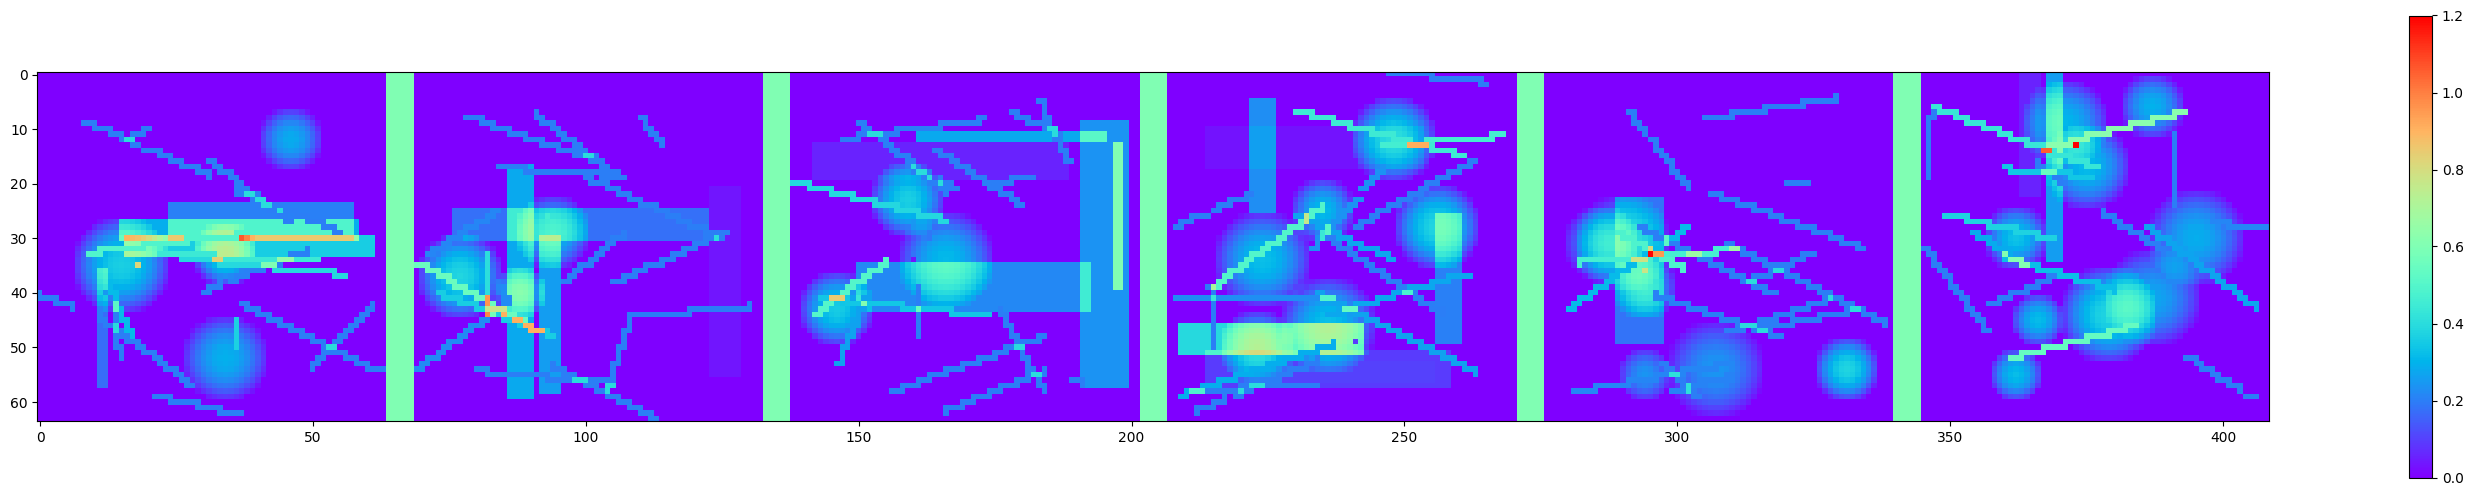

In [122]:
from PREAC.utile_Transformers import voir_batch2D, gen_image_with_pairs, set_tensor_values

# Notre jeu de données contient:
# une cible parfaite (lamedeau)
# des triplets "pluviometres" :
# (lon_pluvio, lat_pluvio, taux de pluie mesuré)
# des quintuplets "cmls" associés aux antennes A & B:
# (lon_A, lat_A, lat_B, lon_B, taux de pluie moyen entre A et B)

batch_size = 6
n_pairs = 16
n_points = 16
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
cmls_spatialises = set_tensor_values(cmls_spatialises, pluviometres, 64)
radar[cmls_spatialises > 0] = cmls_spatialises[cmls_spatialises > 0 ]
voir_batch2D(radar, 6, fig4, k=0, min_scale=0., max_scale=1.2)


**Questions intéressantes** : \\
Pourquoi est-ce que le temps de génération des images est long la première fois qu'on lance le code, mais pas les suivantes ? \\
En quoi les cmls et les pluviomètres peuvent-ils aider à atteindre la cible (c'est à dire la lame d'eau complète) ? \\

## B. Traitement par FCN

A partir des ateliers précédents, il est possible de définir
une approche simple permettant de combiner les trois sources d'information.
Seule obstacle : comment concaténer les entrées. D'où le code suivant:

In [123]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)

In [124]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
pluviometres_spatialises =  -0.1 * torch.ones(radar.shape)
pluviometres_spatialises = set_tensor_values(pluviometres_spatialises, pluviometres, 64)
input = torch.cat([radar, pluviometres_spatialises, cmls_spatialises], dim = 1)
print(input.shape)

torch.Size([6, 3, 64, 64])


**Questions intéressantes** : \\
Pourquoi est-ce qu'on créé une matrice de -0.1 pour les pluviomètres spatialisés ? \\
Comment instancier un UNet pour prendre ce type d'input en entrée ? \\
Visualiser les sorties au bout de cinquante époques (100 batches de 32 par époque).

## C. Encodage des différentes variables qui vont alimenter le transformer

In [126]:
import torch
import torch.nn as nn

class UnifiedEmbedding(nn.Module):
    def __init__(self, d_model, patch_size, channels):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.channels = channels
        self.dim_modality = 4
        # Positional embedding for coordinates
        self.coord_embed = nn.Linear(2, d_model // 3)

        # Modality specific embeddings
        self.patch_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.point_modality = nn.Parameter(torch.randn(self.dim_modality))
        self.segment_modality = nn.Parameter(torch.randn(self.dim_modality))

        # Feature embedding for radar image patches
        self.patch_feature_embed = nn.Conv2d(channels, d_model - self.dim_modality \
                - 2 * (d_model // 3), kernel_size=patch_size, stride=patch_size)

        # Feature embedding for point and segment rain rates
        self.punctual_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                  - 2 * (d_model // 3))
        self.integrated_rain_rate_embed = nn.Linear(1, d_model - self.dim_modality \
                                                    - 2 * (d_model // 3))

    def forward(self, image, points, segments):
        B, C, H, W = image.shape
        device = image.device
        # print("Image shape:", image.shape)

        # Embedding patches
        patch_embeddings = self.patch_feature_embed(image).flatten(2).transpose(1, 2)
        # print("Patch embeddings shape:", patch_embeddings.shape)

        # Create grid for patches
        grid_x, grid_y = torch.meshgrid(torch.arange(0, H, self.patch_size), torch.arange(0, W, self.patch_size), indexing='ij')
        grid_x = grid_x.to(device)  # Move to device
        grid_y = grid_y.to(device)  # Move to device
        upleft = torch.stack((grid_x.flatten(), grid_y.flatten()), dim=-1).float()
        downright = torch.stack((grid_x.flatten() + self.patch_size, grid_y.flatten() + self.patch_size), dim=-1).float()
        # erreur chatGPT !! patch_pos_embeddings = self.coord_embed(upleft) + self.coord_embed(downright)
        patch_pos_embeddings = torch.cat([self.coord_embed(upleft), self.coord_embed(downright)], dim=-1)
        patch_pos_embeddings = patch_pos_embeddings.repeat(B, 1, 1)
        # print("Patch positional embeddings shape:", patch_pos_embeddings.shape)

        patch_embeddings = torch.cat([patch_embeddings, patch_pos_embeddings, self.patch_modality.unsqueeze(0).expand(B, patch_embeddings.size(1), -1)], dim=-1)
        # print("Final patch embeddings shape:", patch_embeddings.shape)

        # Embedding points
        point_pos_embeddings = self.coord_embed(points[..., :2].float())
        # print("Point positional embeddings shape:", point_pos_embeddings.shape)

        point_feature_embeddings = self.punctual_rain_rate_embed(points[..., 2:].float())
        point_embeddings = torch.cat([point_feature_embeddings, point_pos_embeddings, point_pos_embeddings, self.point_modality.unsqueeze(0).expand(B, points.size(1), -1)], dim=-1)
        # print("Final point embeddings shape:", point_embeddings.shape)

        # Embedding segments
        seg_pos_embeddings0 = self.coord_embed(segments[..., :2].float())
        seg_pos_embeddings1 = self.coord_embed(segments[..., 2:4].float())
        segment_feature_embeddings = self.integrated_rain_rate_embed(segments[..., 4:].float())
        segment_embeddings = torch.cat([segment_feature_embeddings, seg_pos_embeddings0, seg_pos_embeddings1, self.segment_modality.unsqueeze(0).expand(B, segments.size(1), -1)], dim=-1)
        # print("Final segment embeddings shape:", segment_embeddings.shape)

        # Concatenate all embeddings
        embeddings = torch.cat([patch_embeddings, point_embeddings, segment_embeddings], dim=1)


        return embeddings



class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        # Nombre de "têtes"
        self.heads = n_heads

        # Taille des vecteurs requête, clefs, valeur
        self.head_dim = d_model // n_heads

        # Scalaire utilisé à l'étape de normalisation
        self.scale = self.head_dim ** -0.5

        # Première application linéaire
        self.qkv = nn.Linear(d_model, n_heads * self.head_dim * 3)

        # Seconde application linéaire
        self.proj = nn.Linear(n_heads * self.head_dim, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape

        # Calcul des requêtes, clefs, valeurs
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )
        # Produits scalaires
        p = (q @ k.transpose(-2, -1))

        # print(q.shape, k.transpose(-2, -1).shape)

        # Etape de normalisation
        p *= self.scale
        p = p.softmax(dim=-1)

        # Somme pondérée
        x = (p @ v).transpose(1, 2).reshape(B, N, C)

        # Sortie
        x = self.proj(x)

        return x

class AttentionWhere(nn.Module):
    def __init__(self, d_model, d_where, n_heads):
        super().__init__()

        # Nombre de "têtes"
        self.heads = n_heads
        self.d_where = d_where
        # Taille des vecteurs requête, clefs, valeur
        self.head_dim = d_where // n_heads

        # Scalaire utilisé à l'étape de normalisation
        self.scale = self.head_dim ** -0.5

        # Première application linéaire
        self.qkv = nn.Linear(d_where, n_heads * self.head_dim * 3, bias = False)
        with torch.no_grad():
          self.qkv.weight.data.fill_(1.0)
        # self.qkv.weight.requires_grad = False

        # init .q and k to 1:

        # Seconde application linéaire
        self.proj = nn.Linear(d_where, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape
        # print(x.shape)
        # print(self.qkv(x[:,:,:self.d_where]).shape)
        # Calcul des requêtes, clefs, valeurs
        qkv = (
            self.qkv(x[:,:,:self.d_where]) # the d_where first channel correspond to position
            .reshape(B, N, 3, self.heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )
        # Produits scalaires
        p = (q @ k.transpose(-2, -1))

        # print(q.shape, k.transpose(-2, -1).shape)

        # Etape de normalisation
        p *= self.scale
        eps = 10**-7
        p = p**2 / (eps + torch.sum(p**2, dim=-1, keepdim=True))

        # Somme pondérée
        x = (p @ v).transpose(1, 2).reshape(B, N, self.d_where)

        # Sortie
        x = self.proj(x)

        return x


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)

    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

# ou avec dropout
import torch.nn.init as init
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None, dropout_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        init.normal_(self.fc1.weight, std=0.02)  # Example initialization
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)
        init.normal_(self.fc2.weight, std=0.02)  # Example initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc2(x)
        return x
"""
class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        #a modifier (voir question 14)
        y = self.attn(self.norm1(x), mask)
        y = self.mlp(self.norm2(y))
        return y
"""
class WhatAndWhereBlock(nn.Module):
    def __init__(self, d_model, d_where, n_heads, n_heads_where, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.whereattn = AttentionWhere(d_model, d_where, n_heads_where)
        self.whatattn = Attention(d_model, n_heads - n_heads_where)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        #a modifier (voir question 14)
        y = self.whatattn(self.norm1(x), mask)
        y += self.whereattn(x)
        y = self.mlp(self.norm2(y))
        return y



class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)

    def forward(self, x, mask=None, return_attention=False):
        x_attn = self.norm1(x)
        if return_attention:
            y, attn_weights = self.attn(x_attn, mask, return_attention=True)
        else:
            y = self.attn(x_attn, mask)
        # Applying skip connection around the attention layer
        y = x + y

        x_mlp = self.norm2(y)
        y = self.mlp(x_mlp)
        # Applying skip connection around the MLP layer
        y = y + x_mlp

        if return_attention:
            return y, attn_weights
        return y


from einops import rearrange



def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        try:
          nn.init.constant_(m.bias, 0)
        except:
          pass
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

def trunc_normal_(tensor, mean=0, std=1):
    nn.init.trunc_normal_(tensor, mean=mean, std=std)


class Up0(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up0, self).__init__()  # Corrected super call
        self.up = nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class Decoder(nn.Module):
    """
    vaut uniquement si channels = 1 et image_size =64
    """
    def __init__(self, patch_size, d_model):
        super().__init__()

        self.d_model = d_model
        self.ps = patch_size
        self.up =  Up0(d_model, 32)
        self.up2 =  Up0(32, 16)
        # self.up3 =  Up0(8, 4)
        self.outc = outconv(16, 5)

    def forward(self, x):

        x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
        x = self.up(x)
        x = self.up2(x)
        # x = self.up2(x)
        # x = self.up3(x)
        x = self.outc(x)
        return x


# class Decoder(nn.Module):
#     """
#     vaut uniquement si channels = 1 et image_size =64
#     """
#     def __init__(self, patch_size, d_model):
#         super().__init__()

#         self.d_model = d_model
#         self.ps = patch_size
#         self.up =  Up0(d_model, 8)
#         # self.up2 =  Up0(16, 8)
#         # self.up3 =  Up0(8, 4)
#         self.outc = outconv(8, 1)

#     def forward(self, x):
#         x = rearrange(x, "b (h w) c -> b c h w", h=64 // self.ps)
#         x = self.up(x)
#         # x = self.up2(x)
#         # x = self.up2(x)
#         # x = self.up3(x)
#         x = self.outc(x)
#         return x

class FusionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        channels=1,
    ):
        super().__init__()
        self.ue = UnifiedEmbedding(d_model, patch_size, channels)
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        n_heads_where = 2
        d_where = d_model // 3
        self.whatandwhereblock = WhatAndWhereBlock(d_model, d_where,
                                                   n_heads, n_heads_where,
                                                   d_ff)
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for _ in range(n_layers - 1)]
        )
        self.norm = nn.LayerNorm(d_model)

        # self.apply(init_weights)

        self.decoder = Decoder(patch_size, d_model)

        self.p = torch.nn.Parameter(torch.ones(16))

    def forward(self, x, y, z):
        # Embed signal
        x = self.ue(x, y, z)  # (B, N, D)

        # Process through each transformer block
        x = self.whatandwhereblock(x)

        for block in self.blocks:
            x = block(x)

        # Apply final normalization
        x = self.norm(x)
        x = x[:,:256,:]

        x = self.decoder(x)

        return x




In [110]:
# Paramètres du modèle :
image_size = [64,64]
channels = 1
patch_size = 4
d_model = 120
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 6
n_layers = 12

In [127]:
# Module interne du réseau responsable de l'encodage des variables :
from PREAC.utile_Transformers import UnifiedEmbedding
ue = UnifiedEmbedding(d_model, patch_size, channels)


In [128]:
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
embeddings = ue(radar, pluviometres, cmls)
print(embeddings.shape)

torch.Size([6, 288, 120])


**Question intéressante** : \\
Comment interpréter les dimensions de l'input après encodage ? \\


## D. Entraînement du Transformer

In [112]:
qkv = nn.Linear(2, 3, bias = False)
with torch.no_grad():
  qkv.weight.fill_(1.0)

In [115]:
# from PREAC.utile_Transformers import FusionTransformer
torch.manual_seed(0)
model = FusionTransformer(image_size, patch_size, n_layers, d_model, d_ff, n_heads, channels=1)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)
model(radar, pluviometres, cmls).shape

torch.Size([6, 5, 64, 64])

In [129]:
def criterion(output, target):
    return torch.abs((output - target)).mean()

import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), 10**(-4))
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, total_iters=40)
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=0.00001)
# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[20])

In [117]:
import torch
bce = torch.nn.BCELoss()
# bce = torch.nn.BCELoss(reduction='none')
m = torch.nn.Sigmoid()

l1 = torch.nn.L1Loss()
l2 = torch.nn.MSELoss()

In [130]:
def f1(x, y, alpha = 100.):
  loss = bce(x, y)
  alphat = torch.full_like(y, 1)
  alphat[y==1] = alpha
  loss *= alphat
  return loss.mean()


In [131]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def create_conic_kernel(size=17, ray=8):
    """
    Create a 2D conic kernel using the given size and ray.
    The kernel's maximum value is 1 at the center and decreases linearly to 0 at the edges.
    """
    x_center = size // 2
    y_center = size // 2

    # Create coordinate tensors using meshgrid
    x = torch.arange(size).float()
    y = torch.arange(size).float()
    xx, yy = torch.meshgrid(x, y, indexing='ij')

    # Calculate the conic kernel
    distances = ((ray**2 - (xx - x_center)**2 - (yy - y_center)**2).clamp(min=0))
    kernel = distances / ray
    return kernel

In [90]:
def smooth(tensor, kernel):
    """
    Smooth the input 4D tensor (B, C, H, W) by applying the given kernel along the C dimension.
    :param tensor: 4D torch tensor of shape (B, C, H, W)
    :param kernel: 2D torch tensor (the conic kernel)
    :return: Smoothed tensor of the same shape as the input
    """
    B, C, H, W = tensor.shape

    # Ensure kernel is 2D
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, K, K)

    # Calculate padding size
    pad_size = kernel.size(-1) // 2

    # Reshape input tensor to merge batch and channel dimensions
    input_tensor = tensor.view(B * C, 1, H, W)  # Shape: (B*C, 1, H, W)

    # Apply padding to both height and width dimensions
    padded_tensor = F.pad(input_tensor, (pad_size, pad_size, pad_size, pad_size), mode='constant', value=0)

    # Perform convolution without groups
    smoothed = F.conv2d(padded_tensor, kernel)  # No need for groups

    # Reshape back to the original dimensions
    smoothed = smoothed.view(B, C, H, W)

    return smoothed



In [77]:
pluviometres_spatialises.shape

torch.Size([64, 1, 64, 64])

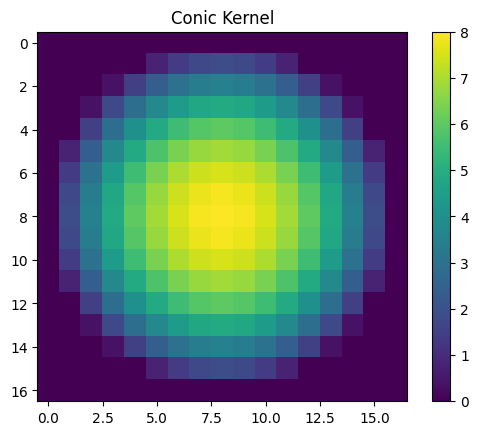

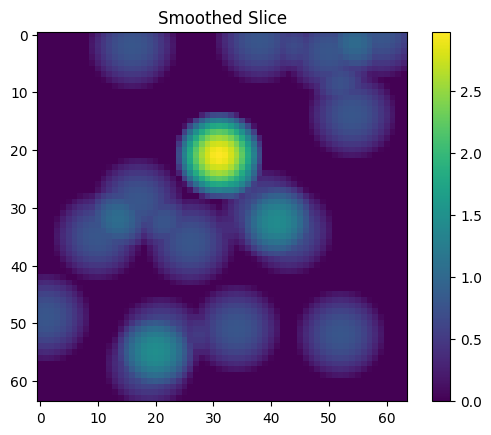

In [91]:
kernel = create_conic_kernel(size=17, ray=8)

# Visualize the kernel
plt.imshow(kernel, cmap="viridis")
plt.colorbar()
plt.title("Conic Kernel")
plt.show()

# Create a dummy input tensor
B, C, H, W = 1, 60, 64, 64
input_tensor = torch.zeros((B, C, H, W))
input_tensor[:, :, 32, 32] = 1  # Activate a single pixel in each channel

# Smooth the input tensor
smoothed_tensor = smooth(pluviometres_spatialises.cpu(), kernel)

# Visualize one smoothed slice
plt.imshow(smoothed_tensor[0, 0].detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title("Smoothed Slice")
plt.show()

In [132]:
nepochs = 500
nbatches = 100
batchsize = 64
train_losses = []
device = torch.device('cuda:0')
model = model.to(device)
kernel = kernel.cuda()
iters = nbatches

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []

    for i in range(nbatches):
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(batchsize, n_pairs, n_points)
        lamedeau, pluviometres, radar, cmls_spatialises, cmls = lamedeau.cuda(), pluviometres.cuda(), radar.cuda(), cmls_spatialises.cuda(), cmls.cuda()
        pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
        pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)

        optimizer.zero_grad()
        outputs = model(radar, pluviometres, cmls)
        smoothed_pluviometres = smooth(pluviometres_spatialises, kernel)

        loss1 = bce(m(outputs[:,[1]]), (cmls_spatialises > 0).float())
        loss2 = l1(outputs[:,[2]][cmls_spatialises>0], cmls_spatialises[cmls_spatialises>0])
        loss3 = bce(m(outputs[:,[3]]), (smoothed_pluviometres > 0).float())
        loss4 = l1(outputs[:,[4]][smoothed_pluviometres>0], smoothed_pluviometres[smoothed_pluviometres>0])

        loss = 1/(2*model.p[1]**2) * loss1 + 1/(2*model.p[2]**2) * loss2 + 1/(2*model.p[3]**2) * loss3 + 1/(2*model.p[4]**2) * loss4
        loss += torch.log(1 + model.p[1]**2 + model.p[2]**2 + model.p[3]**2 + model.p[4]**2)
        # print(loss1.item(), loss2.item(), loss3.item(), loss4.item())

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.detach().cpu().item())

    scheduler.step()

    print('lr scheduler', scheduler.get_last_lr())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')


Epoch 1/500
lr scheduler [2.5975e-06]
Epoch loss: 2.2034
Epoch 2/500


KeyboardInterrupt: 

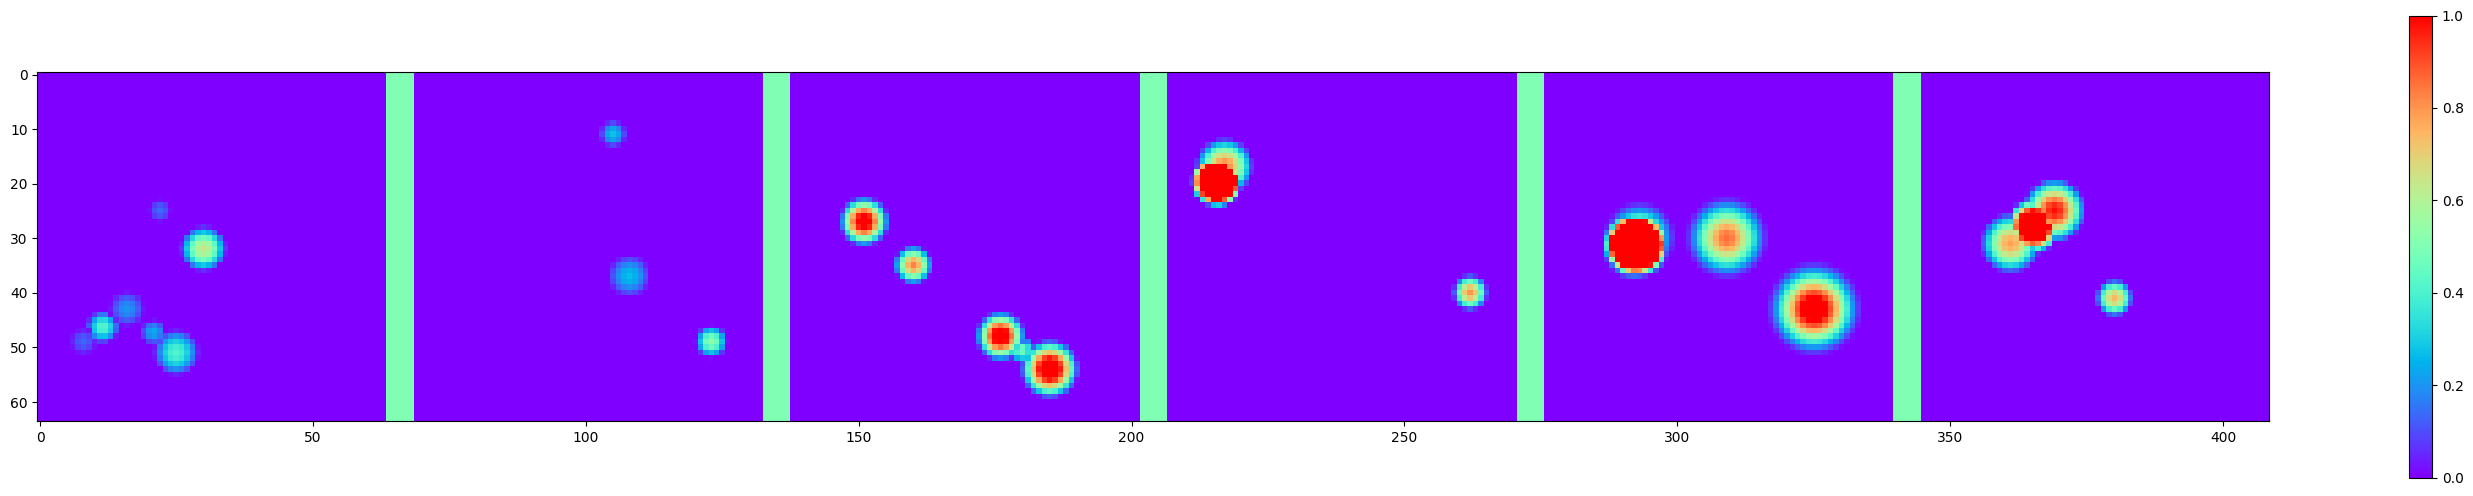

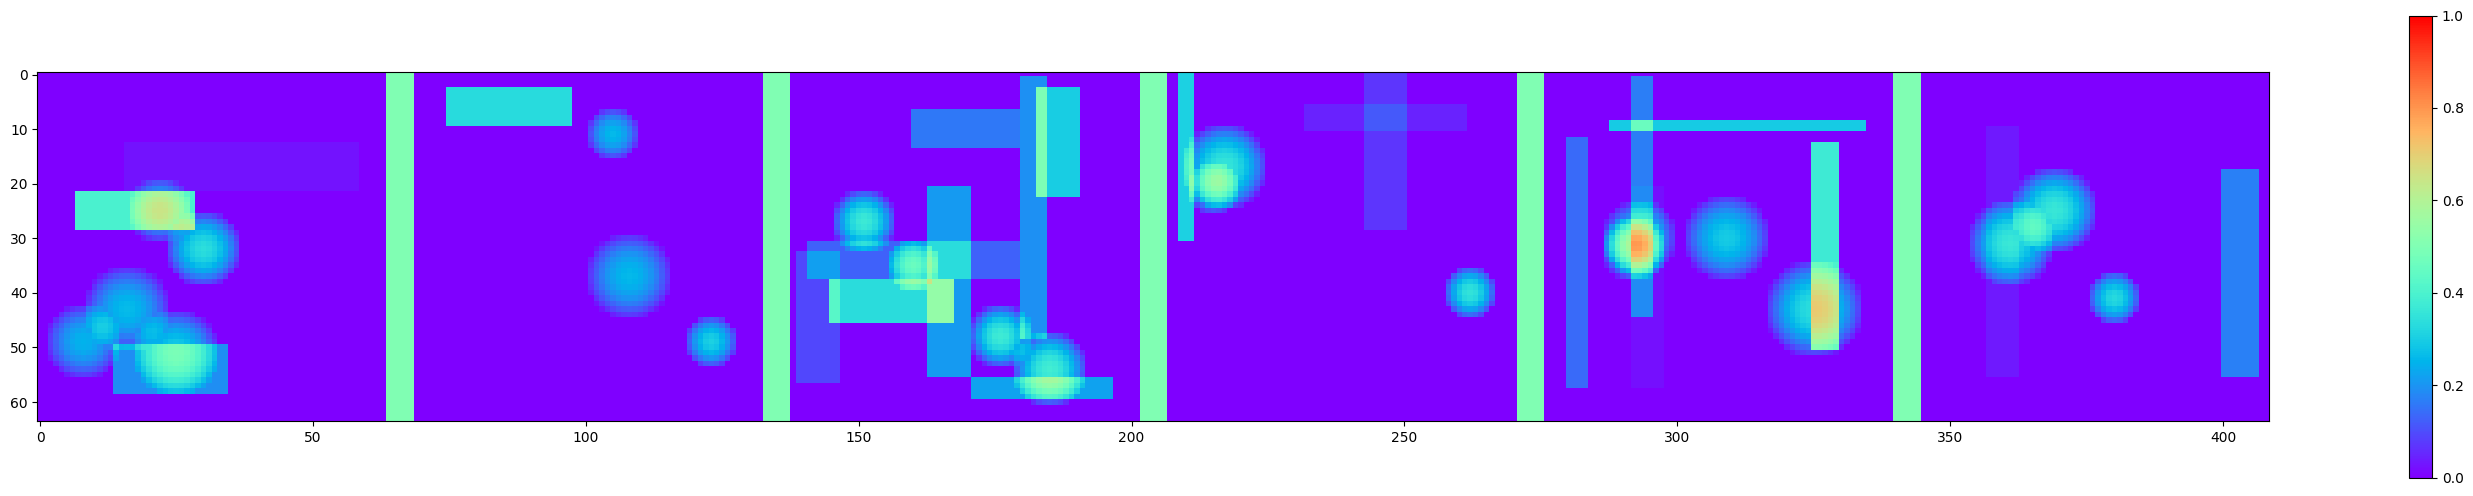

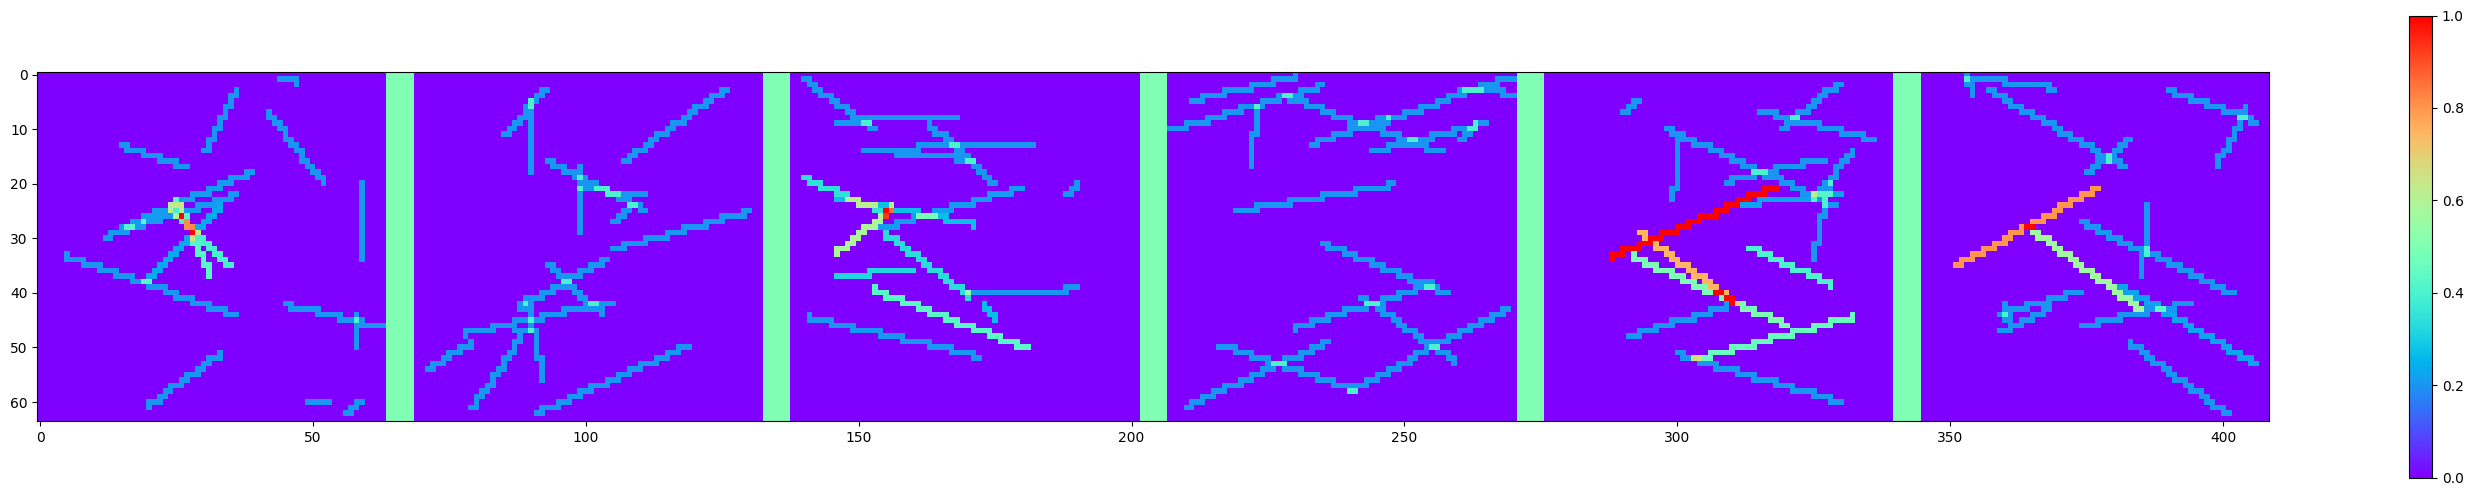

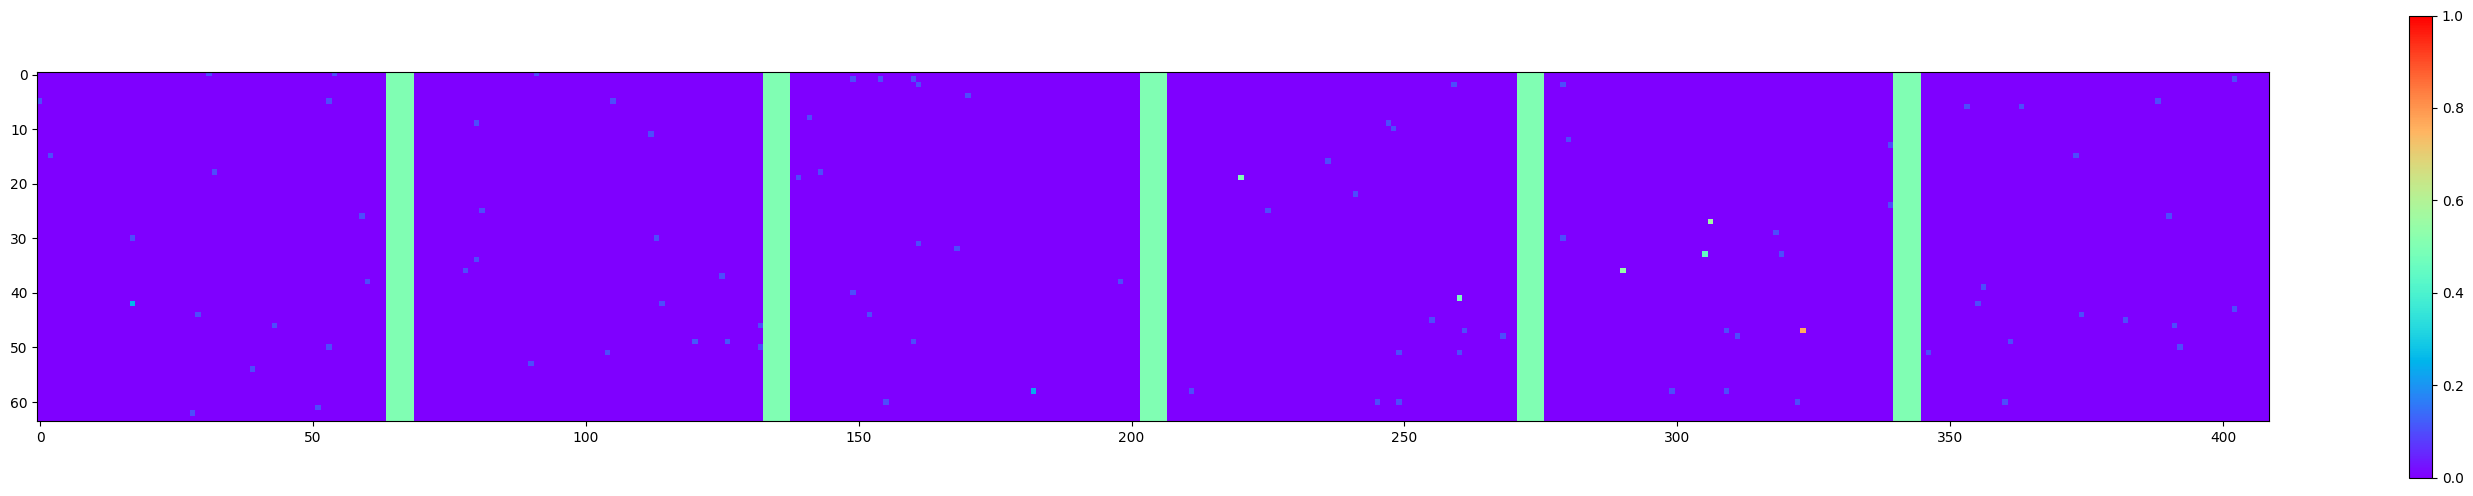

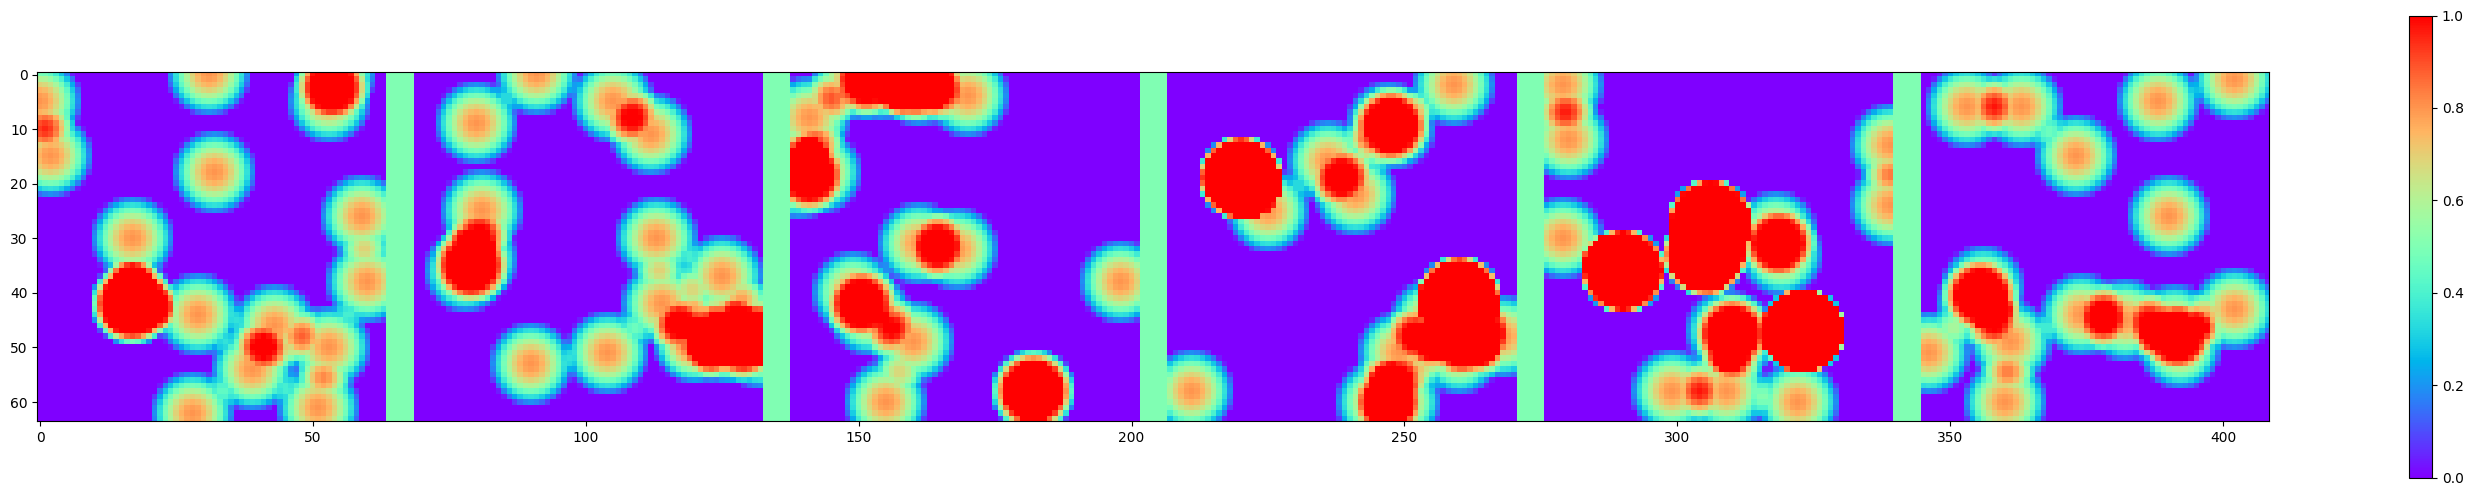

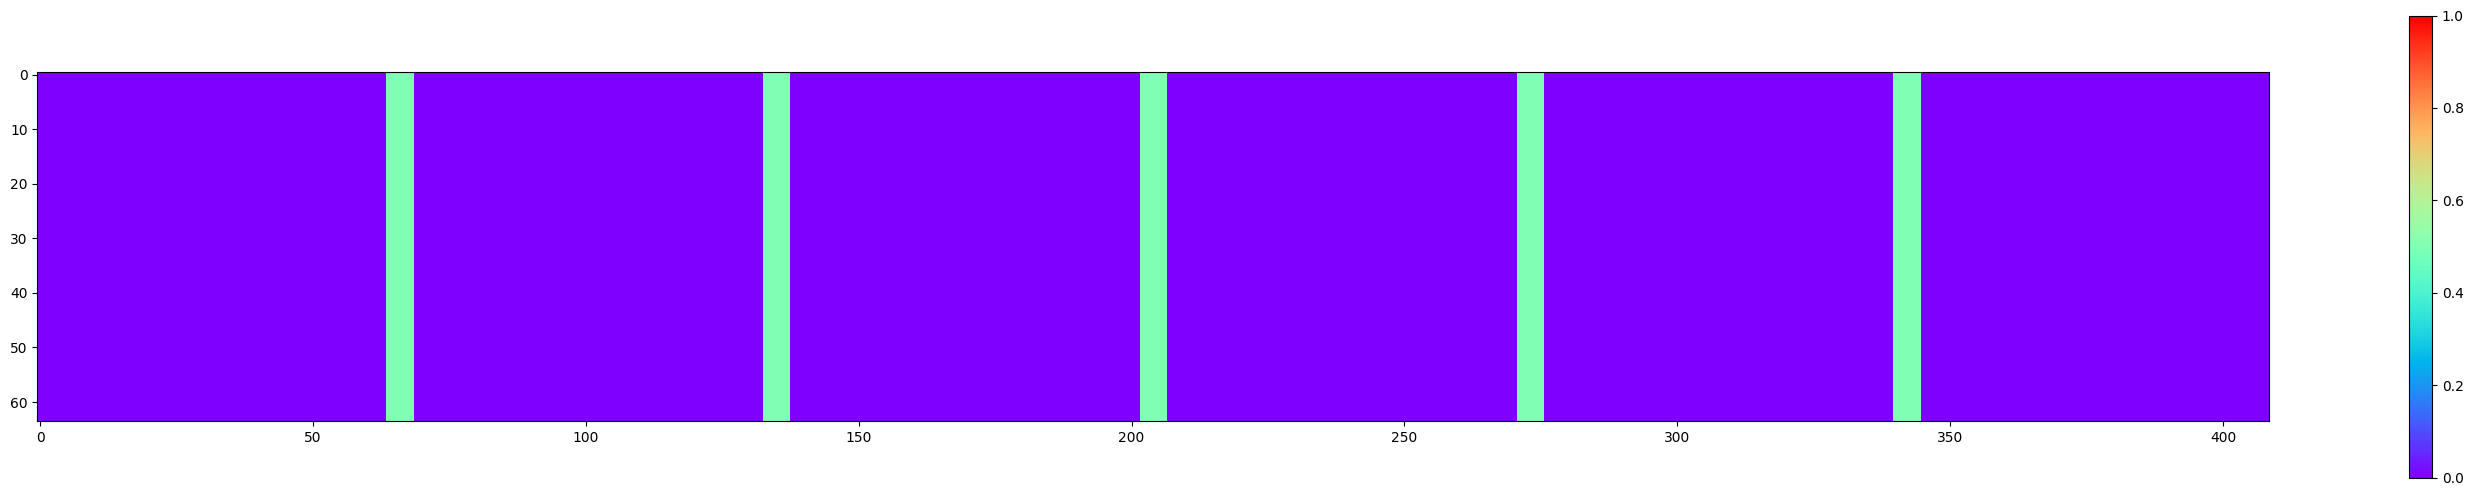

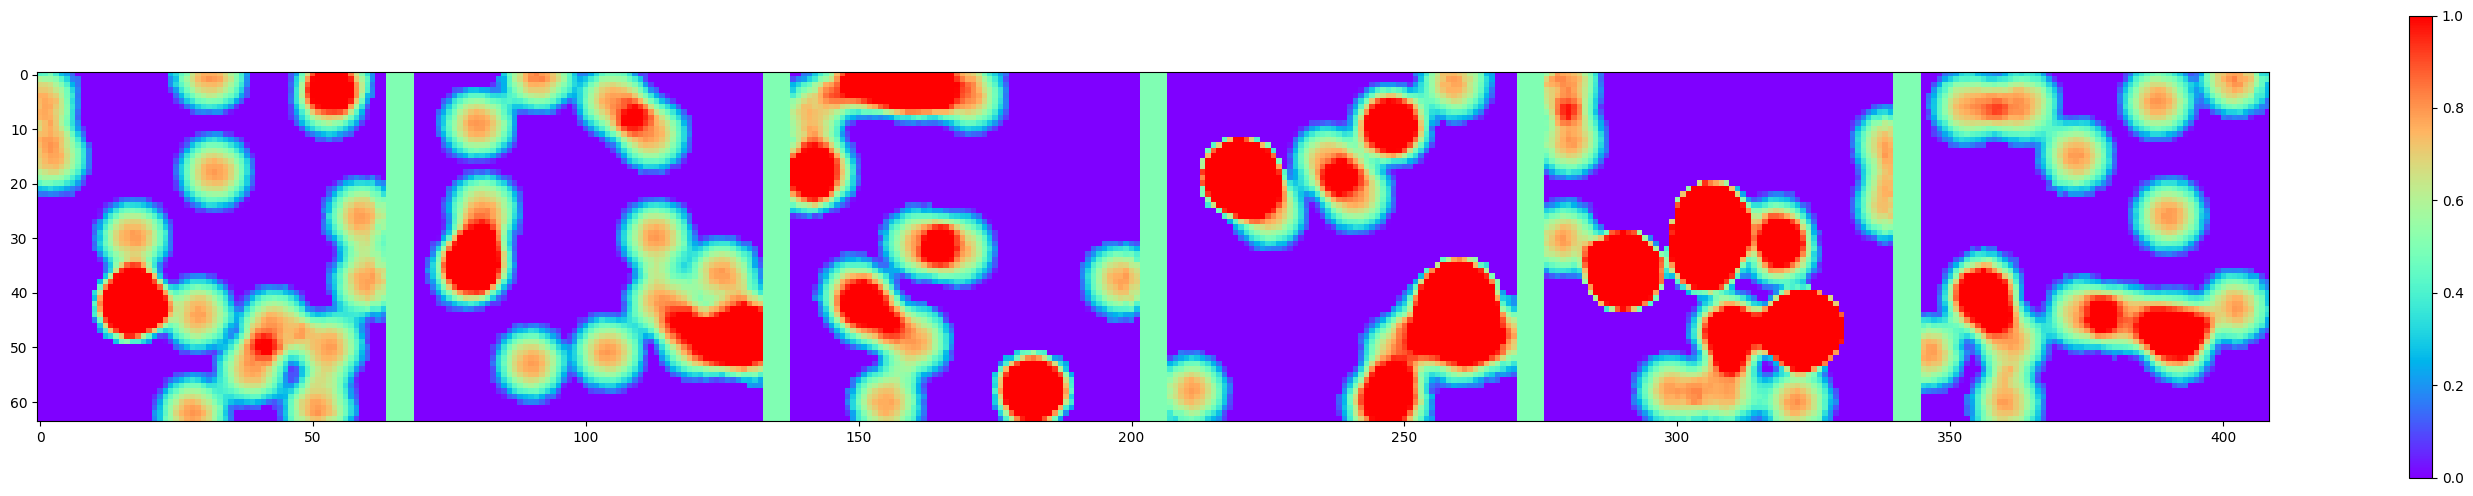

In [ ]:
    #visualization:
# epoque 300 : l'un a convergé mais pas l'autre
model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)
pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)
targets = smooth(pluviometres_spatialises, kernel.cpu())
outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig0= plt.figure(0, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig0, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(radar, 6, fig1, k=0, min_scale=0, max_scale=1)

# cmls
fig1 = plt.figure(2, figsize=(36, 6))
voir_batch2D(cmls_spatialises, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(pluviometres_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(targets.cpu(), 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
voir_batch2D((m(outputs[:,[1]]) > 0.5)*outputs[:,[2]], 6, fig4, k=0, min_scale=0, max_scale=1)


# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig5 = plt.figure(5, figsize=(36, 6))
voir_batch2D((m(outputs[:,[3]]) >0.5)*outputs[:,[4]], 6, fig5, k=0, min_scale=0, max_scale=1)

In [ ]:
targets.shape

torch.Size([64, 1, 64, 64])

**Questions intéressantes** : \\
Quelle différence qualitative entre les outputs ? \\
Que doit faire le transformer "en plus", comparé au FCN ?



## E. Chargement d'un Transformer entraîné

In [ ]:
# Avec France Transfert ??
# !curl 'https://francetransfert.numerique.gouv.fr/api-private/download-module/generate-download-url' -X POST \
# -H 'Content-Type: application/json' \
# -H 'Origin:https://francetransfert.numerique.gouv.fr' \
# --data-raw '{"enclosure":"164ea132-cf5e-4a8d-a084-62841b3122ec","recipient":"cGllcnJlLmxlcGV0aXRAbWV0ZW8uZnI%3D","token":"ddf68980-7b19-4eef-8a34-88a3e32a0f71","senderToken":null,"password":"2q*vbl62!FK@Z"}'

In [ ]:
# Modèles entraînés sur 900 époques :
# mViT_900ep.pth comme au D.
# mViT_0radar_900ep.pth avec, au préalable: radar = 0 x radar
! wget https://www.grosfichiers.com/K3aaxZcSnX4_Fic8rPjJ9yZ
! unzip K3aaxZcSnX4_Fic8rPjJ9yZ
! rm K3aaxZcSnX4_Fic8rPjJ9yZ

In [ ]:
# charger un checkpoint avec torch .load
# visualiser les outputs

checkpoint = torch.load('mViT_900ep.pth')
model.load_state_dict(checkpoint['model_state_dict'])

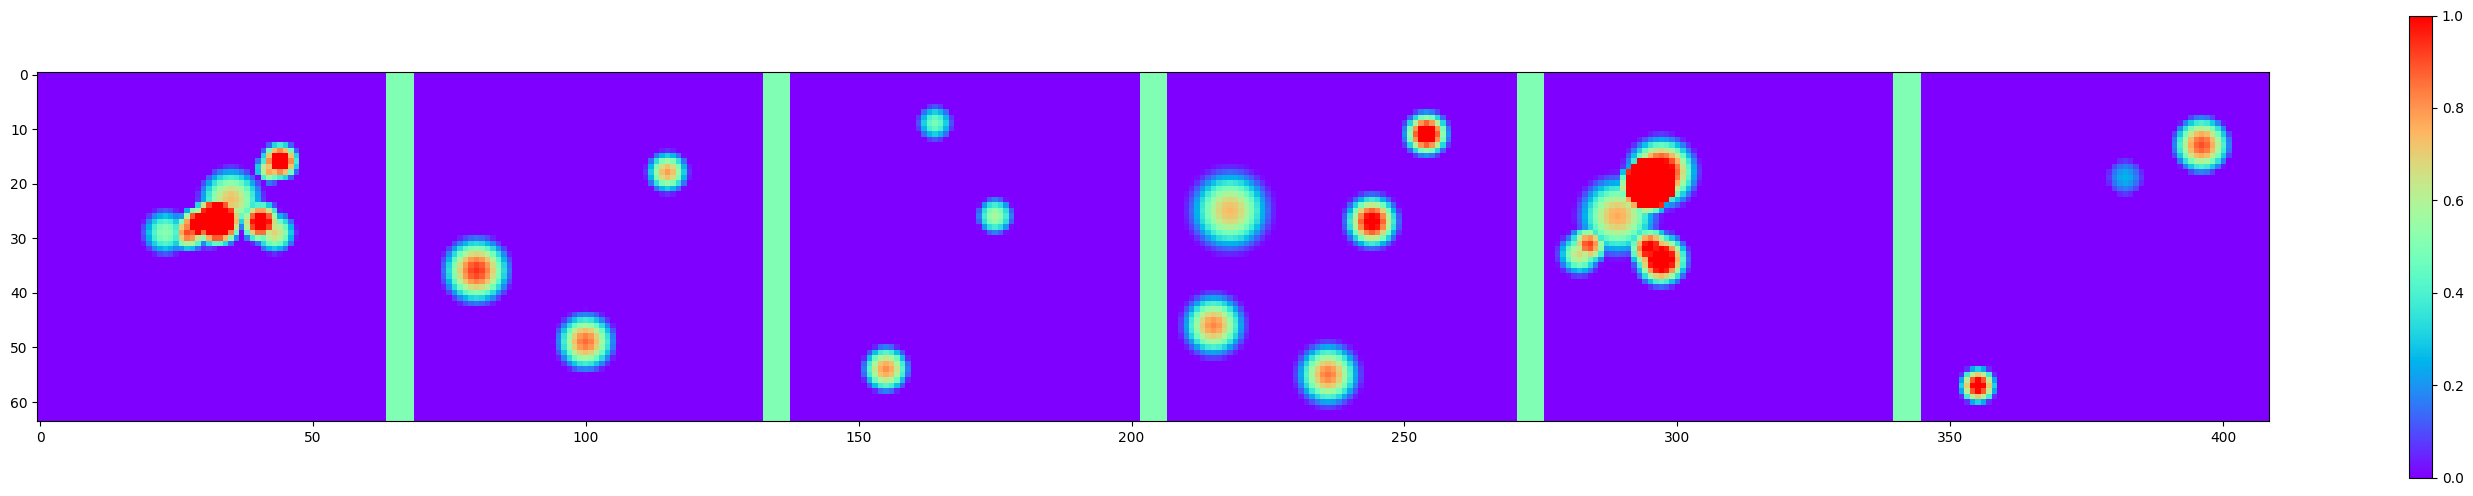

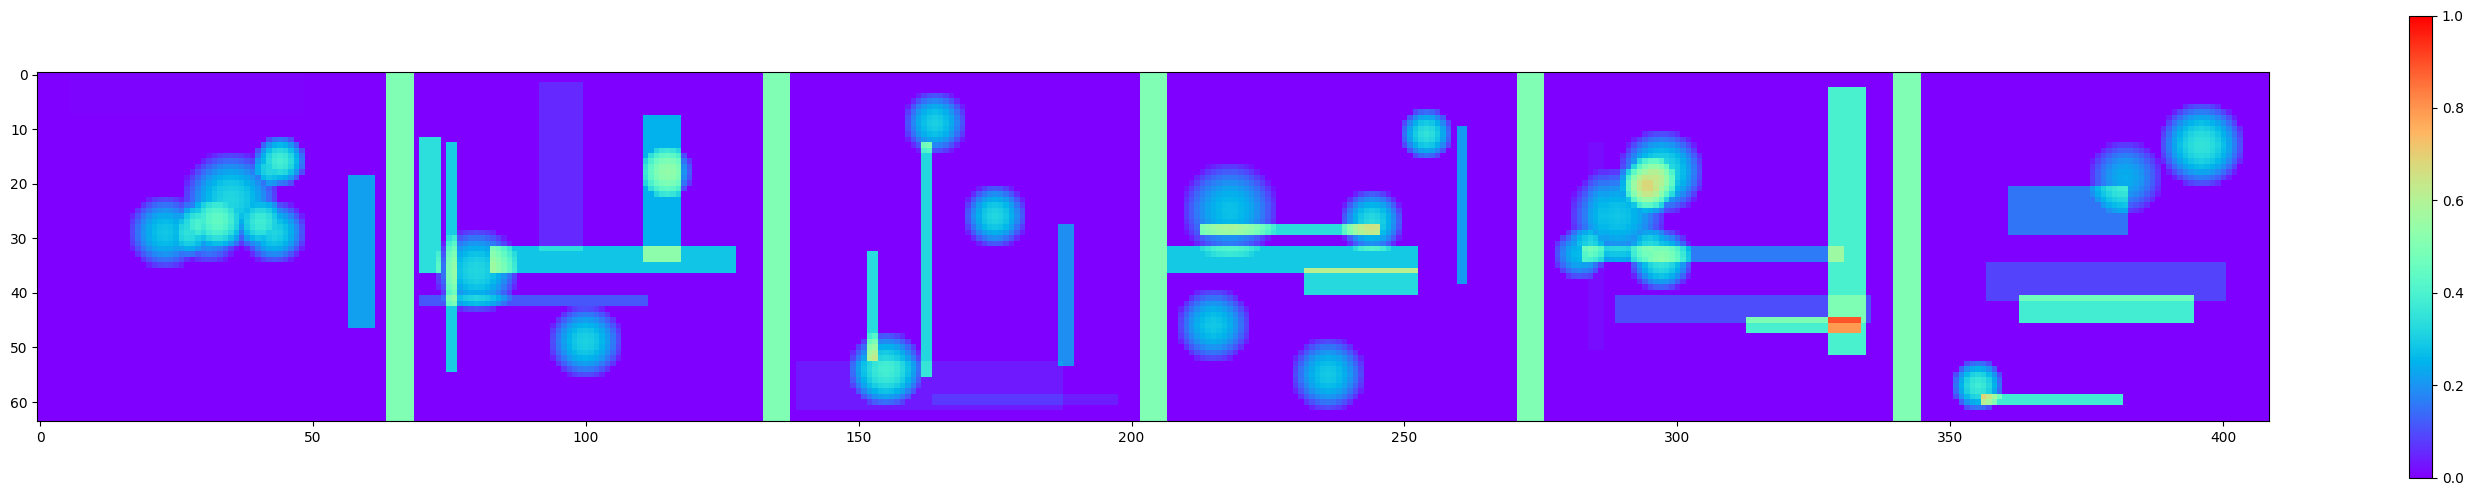

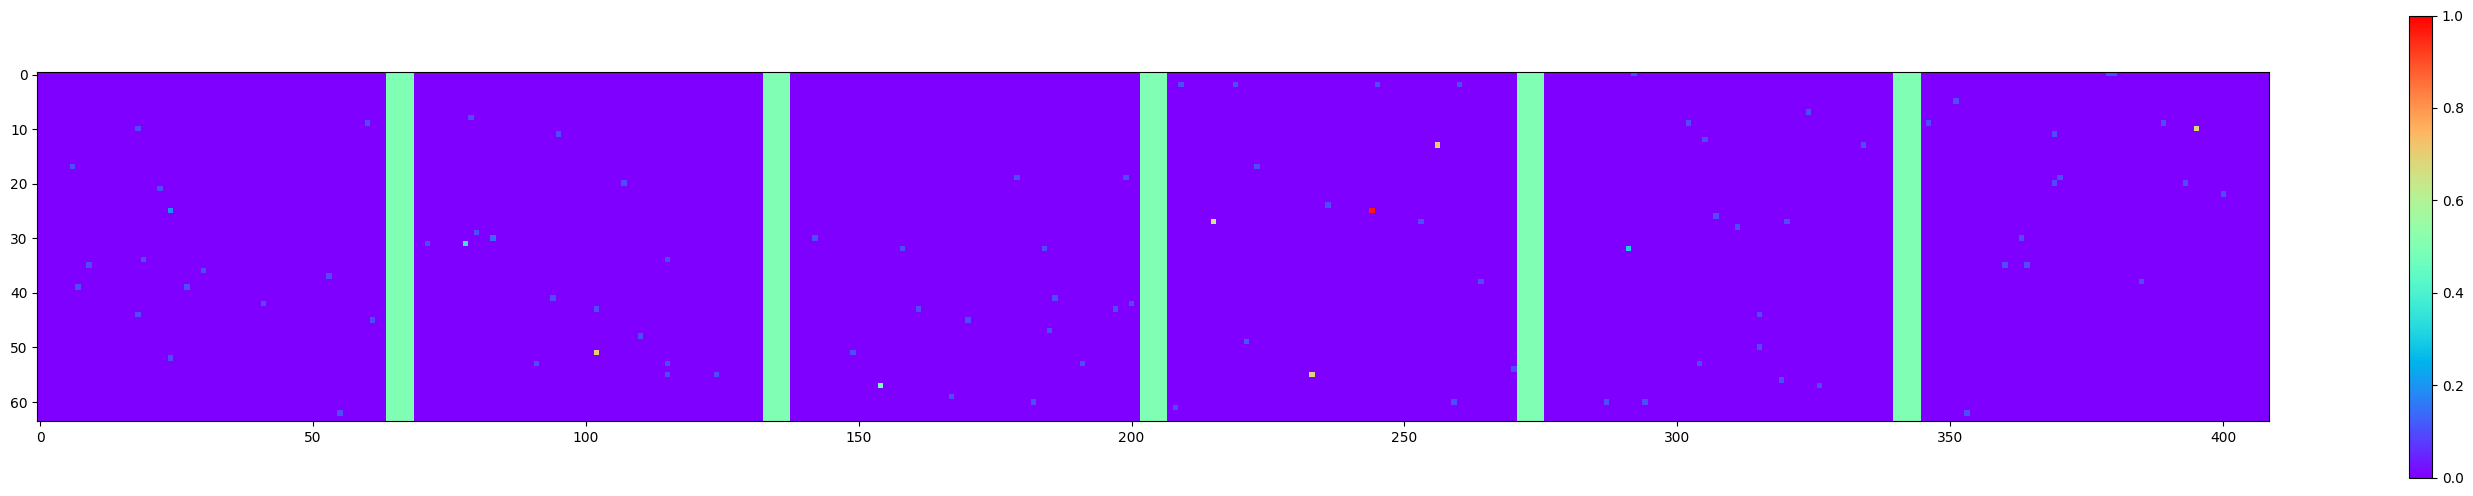

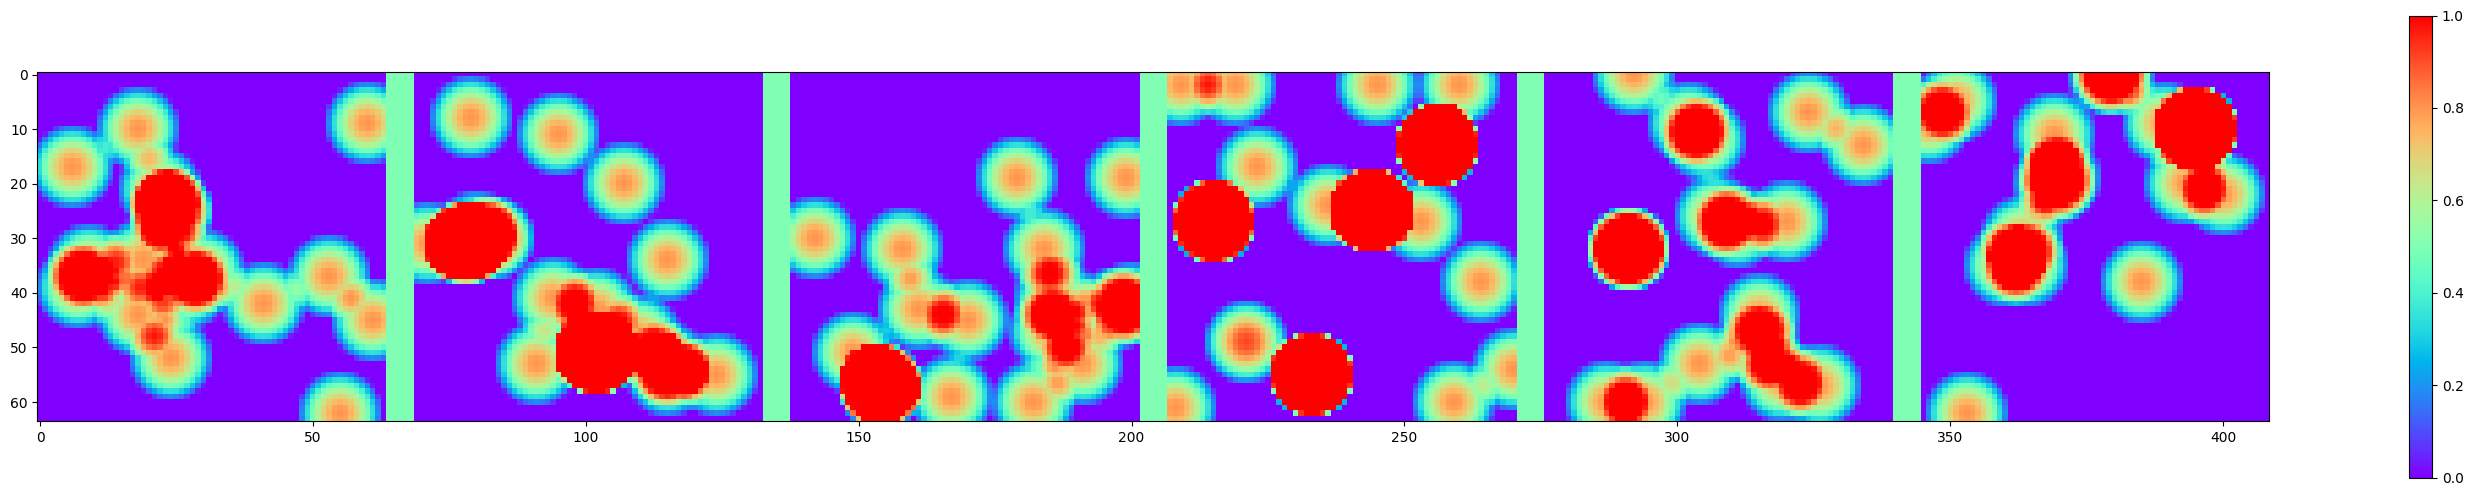

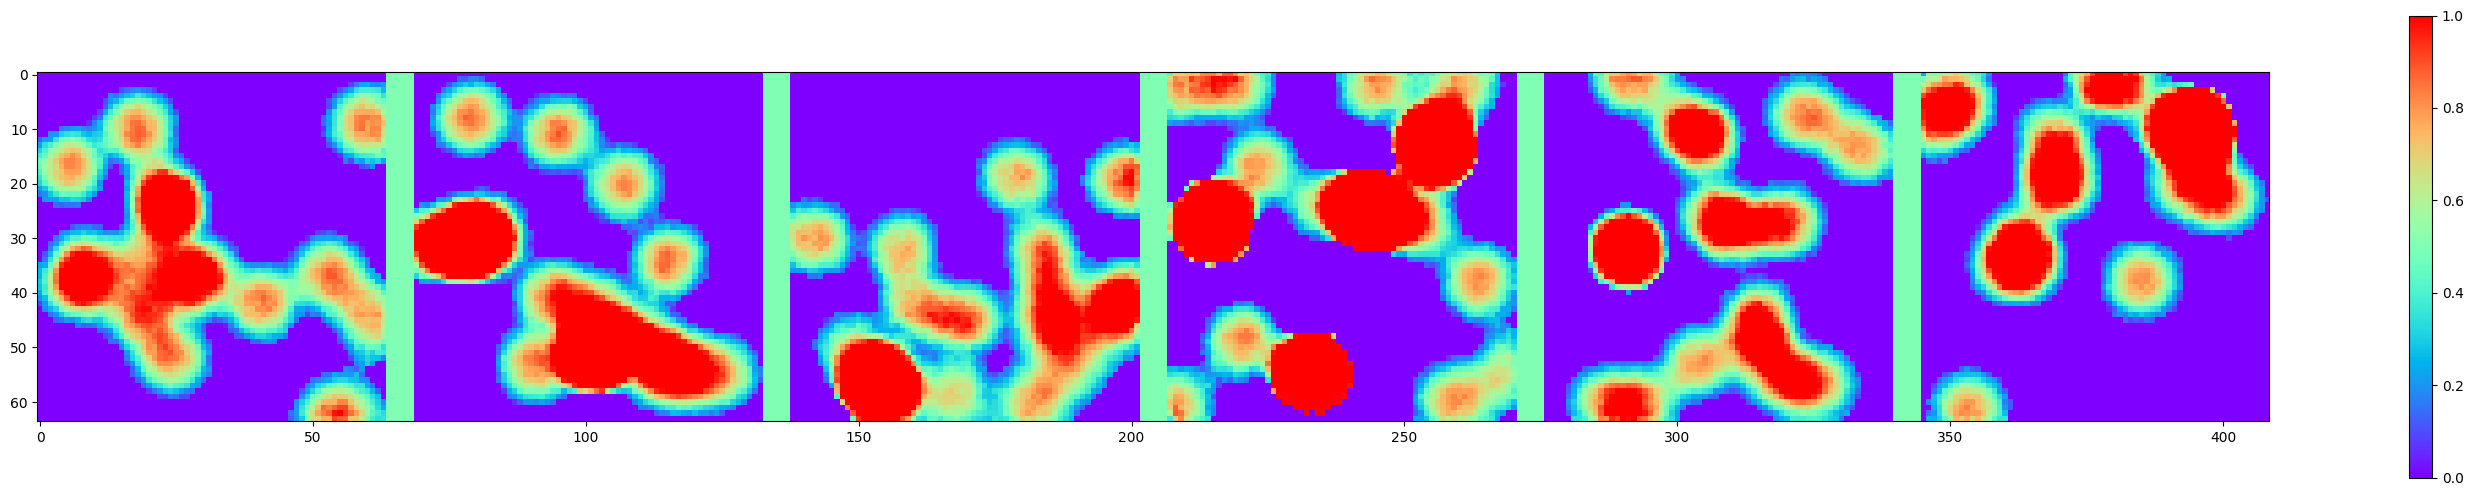

In [ ]:
#visualization:

model.eval()

full_target, partial_target, noisy_images, traces, pairs_list = gen_image_with_pairs(6, n_pairs, n_points)
lamedeau, pluviometres, radar, cmls_spatialises, cmls = gen_image_with_pairs(6, n_pairs, n_points)


radar = radar.to(device)
cmls = cmls.to(device)
pluviometres = pluviometres.to(device)
pluviometres_spatialises = torch.full_like(lamedeau, -0.1)
pluviometres_spatialises = 0.1 + set_tensor_values(pluviometres_spatialises, pluviometres)
targets = smooth(pluviometres_spatialises, kernel.cpu())
outputs = model(radar, pluviometres, cmls)

radar = radar.cpu()
cmls = cmls.cpu()
pluviometres = pluviometres.cpu()
outputs = outputs.cpu().detach()

# lame d'eau "idéale"
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(lamedeau, 6, fig1, k=0, min_scale=0, max_scale=1)

# images radar (bruitées)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(radar, 6, fig2, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(pluviometres_spatialises, 6, fig3, k=0, min_scale=0, max_scale=1)

# Commercial Microwave Links (cmls)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(targets.cpu(), 6, fig3, k=0, min_scale=0, max_scale=1)

# Superposition Commercial Microwave Links (CMLs), pluviomètres et radar
fig4 = plt.figure(4, figsize=(36, 6))
voir_batch2D((m(outputs[:,[0]]) >0.5)*outputs[:,[1]], 6, fig3, k=0, min_scale=0, max_scale=1)



In [ ]:
torch.median(targets.cpu())

tensor(0.)

**Question intéressante** : \\
Le transformer parvient-il à exploiter les valeurs de pluviomètres et des cmls  ?

Bibliographie :  [Jaegle et al. 2020](https://arxiv.org/abs/1811.12739)